In [46]:
import pandas as pd
import numpy as np

In [47]:
dataset_url = '../data/image_classification/train.csv'

In [48]:
data = pd.read_csv(dataset_url, on_bad_lines='skip')

In [49]:
data.head()

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.


## Prepare data

### preprocess

In [50]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jforc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jforc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jforc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jforc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [52]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


def preprocess_text(text):
    # normalisation
    text = text.lower()
    
    text = re.sub(r'[^a-z\s]', '', text)
    
    # tokenization
    tokens = word_tokenize(text)
    
    # suppression des stop words english
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)


data['Processed_Caption'] = data['Caption'].apply(preprocess_text)

### embedding with Glove

In [53]:
import zipfile
import os

import urllib.request

# Download the GloVe embeddings
url = "http://nlp.stanford.edu/data/glove.6B.zip"
filename = "glove.6B.zip"
urllib.request.urlretrieve(url, filename)

# Unzip the file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

In [54]:
#Recuperer les embeddings

glove_file = '../data/glove.6B.300d.txt'

embeddings_index = {}

with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [55]:
# Encode the processed captions using the GloVe embeddings
def encode_caption(caption, embeddings_index, embedding_dim=300):
    words = caption.split()
    embedding_matrix = np.zeros((len(words), embedding_dim))
    for i, word in enumerate(words):
        if word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]
    return np.mean(embedding_matrix, axis=0)

In [56]:
# Convert the embeddings into a DataFrame with each dimension as a column
embedding_columns = [f"dim_{i}" for i in range(300)]
encoded_captions = data['Processed_Caption'].apply(lambda x: encode_caption(x, embeddings_index))
encoded_captions_df = pd.DataFrame(encoded_captions.tolist(), columns=embedding_columns)

# Concatenate the original DataFrame with the embeddings DataFrame
data = pd.concat([data, encoded_captions_df], axis=1)

In [57]:
data.head()

,ImageID,Labels,Caption,Processed_Caption,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,...,dim_290,dim_291,dim_292,dim_293,dim_294,dim_295,dim_296,dim_297,dim_298,dim_299
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.,woman swim suit holding parasol sunny day,-0.183715,-0.279452,-0.273451,-0.151354,-0.238511,-0.002729,...,0.015428,0.145674,-0.210935,0.135643,-0.065155,-0.015965,0.077749,0.149353,0.039941,0.156539
1,1.jpg,1 19,A couple of men riding horses on top of a gree...,couple men riding horse top green field,-0.112222,0.167935,0.051619,-0.060171,-0.141060,0.037239,...,-0.080701,0.077541,-0.399331,0.073074,0.064750,0.179167,0.028870,0.033079,0.104596,0.074339
2,2.jpg,1,They are brave for riding in the jungle on tho...,brave riding jungle elephant,-0.104130,-0.147420,0.039692,0.108273,-0.014261,0.136308,...,0.015092,0.207167,-0.373578,-0.070615,-0.040367,0.333992,-0.282195,0.345185,0.204967,0.251706
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...,black silver clock tower intersection near tree,-0.239927,-0.025673,-0.033024,-0.293050,-0.115065,0.097724,...,0.164644,0.028476,-0.188698,0.093664,-0.039222,0.201370,0.273574,-0.046140,0.074232,0.105175
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.,train coming stop track side,0.166052,0.105928,0.030769,0.035441,-0.339333,-0.209551,...,-0.050368,-0.224060,-0.257643,0.074137,0.046986,0.190455,0.036208,-0.144133,0.183855,0.131850


### split

_J'utilise le csv que j'ai cree avec le split des images pour avoir la meme repartition_

In [58]:
split_train = pd.read_csv('../data/image_classification/split_train.csv')
split_val = pd.read_csv('../data/image_classification/split_val.csv')
split_test = pd.read_csv('../data/image_classification/split_test.csv')


In [59]:
train = data[data['ImageID'].isin(split_train['ImageID'])].merge(split_train, on='ImageID', how='left')
val = data[data['ImageID'].isin(split_val['ImageID'])].merge(split_val, on='ImageID', how='left')
test = data[data['ImageID'].isin(split_test['ImageID'])].merge(split_test, on='ImageID', how='left')

In [60]:
train.shape, val.shape, test.shape

((21004, 323), (4501, 323), (4491, 323))

In [61]:
train.head()

,ImageID,Labels,Caption_x,Processed_Caption,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,...,9,10,11,13,14,15,16,17,18,19
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.,woman swim suit holding parasol sunny day,-0.183715,-0.279452,-0.273451,-0.151354,-0.238511,-0.002729,...,0,0,0,0,0,0,0,0,0,0
1,2.jpg,1,They are brave for riding in the jungle on tho...,brave riding jungle elephant,-0.104130,-0.147420,0.039692,0.108273,-0.014261,0.136308,...,0,0,0,0,0,0,0,0,0,0
2,3.jpg,8 3 13,a black and silver clock tower at an intersect...,black silver clock tower intersection near tree,-0.239927,-0.025673,-0.033024,-0.293050,-0.115065,0.097724,...,0,0,0,1,0,0,0,0,0,0
3,4.jpg,8 3 7,A train coming to a stop on the tracks out side.,train coming stop track side,0.166052,0.105928,0.030769,0.035441,-0.339333,-0.209551,...,0,0,0,0,0,0,0,0,0,0
4,5.jpg,1,A young man riding a skateboard into the air.,young man riding skateboard air,-0.003960,-0.062320,0.025922,-0.189070,-0.179114,0.299247,...,0,0,0,0,0,0,0,0,0,0


## Modèle baseline

In [62]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


In [63]:
labels_cols = ['1','2','3','4','5','6','7','8','9','10','11','13','14','15','16','17','18','19']

In [64]:

y_train = train[labels_cols]
y_val = val[labels_cols]

# Séparer les caractéristiques (features)
X_train = train[[f"dim_{i}" for i in range(300)]]
X_val = val[[f"dim_{i}" for i in range(300)]]

classes = y_train.columns.tolist()

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

def confusion_marice_multilabel(y_true, y_pred, labels):
    # Calculer la matrice de confusion
    conf_matrix = confusion_matrix(y_true.values.argmax(axis=1), y_pred.argmax(axis=1))

    # Tracer la matrice de confusion
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Logistic Regression Model')
    plt.show()

### Logistic regression

In [65]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression


lr_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_val)

In [66]:
# Calculer les métriques de performance
accuracy = accuracy_score(y_val, y_pred_lr)
f1 = f1_score(y_val, y_pred_lr, average='weighted')
print(f"Random Forest Accuracy: {accuracy:.4f}")
print(f"Random Forest F1 Score: {f1:.4f}")

pd.DataFrame(classification_report(y_val, y_pred_lr, target_names=classes, output_dict=True))

Random Forest Accuracy: 0.6454
Random Forest F1 Score: 0.7833


c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,micro avg,macro avg,weighted avg,samples avg
precision,0.921610,0.873418,0.603604,0.937984,0.983146,0.938547,0.970238,0.801325,0.876190,0.742857,...,0.958333,0.976744,0.946903,0.994845,0.960674,0.969697,0.905576,0.906533,0.889453,0.906276
recall,0.912902,0.431250,0.299107,0.620513,0.925926,0.680162,0.895604,0.366667,0.564417,0.362791,...,0.657143,0.311111,0.618497,0.857778,0.760000,0.895105,0.726454,0.622566,0.726454,0.819078
f1-score,0.917235,0.577406,0.400000,0.746914,0.953678,0.788732,0.931429,0.503119,0.686567,0.487500,...,0.779661,0.471910,0.748252,0.921241,0.848635,0.930909,0.806186,0.724002,0.783257,0.837375
support,3387.000000,160.000000,672.000000,195.000000,189.000000,247.000000,182.000000,330.000000,163.000000,215.000000,...,35.000000,270.000000,173.000000,225.000000,225.000000,143.000000,6997.000000,6997.000000,6997.000000,6997.000000


Mean Average Precision (mAP) Logistic Regression : 0.6019


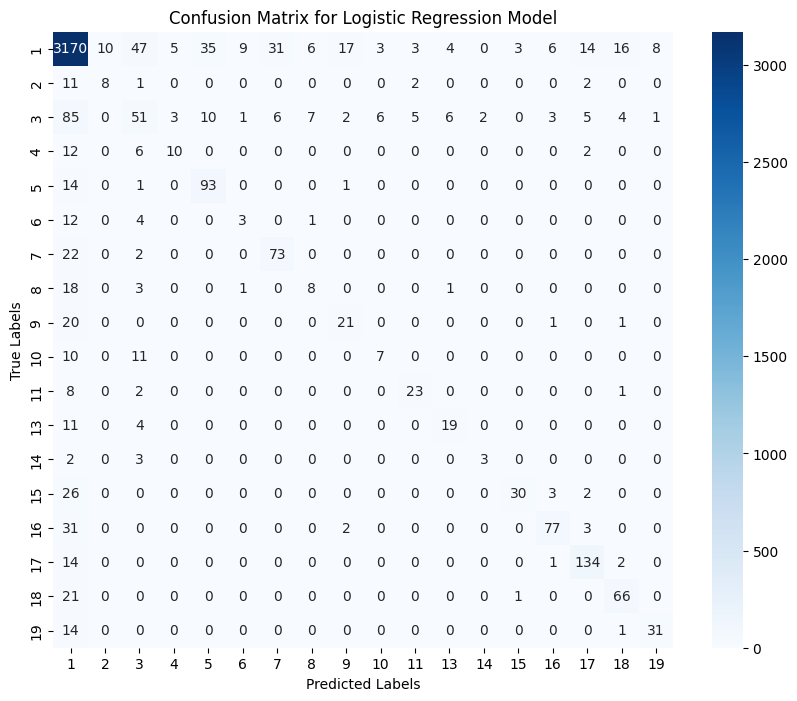

In [145]:
from sklearn.metrics import average_precision_score

average_precisions = []
for i in range(y_val.shape[1]):
    ap = average_precision_score(y_val.iloc[:, i], y_pred_lr[:, i])
    average_precisions.append(ap)


mean_ap = sum(average_precisions) / len(average_precisions)
print(f"Mean Average Precision (mAP) Logistic Regression : {mean_ap:.4f}")

confusion_marice_multilabel(y_val, y_pred_lr, classes)

### Random Forest

In [68]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier


rf_model = OneVsRestClassifier(RandomForestClassifier(random_state=42))
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

In [69]:
# Calculer les métriques de performance
accuracy = accuracy_score(y_val, y_pred_rf)
f1 = f1_score(y_val, y_pred_rf, average='weighted')
print(f"Random Forest Accuracy: {accuracy:.4f}")
print(f"Random Forest F1 Score: {f1:.4f}")

pd.DataFrame(classification_report(y_val, y_pred_rf, target_names=classes, output_dict=True))

Random Forest Accuracy: 0.5641
Random Forest F1 Score: 0.6722


c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,micro avg,macro avg,weighted avg,samples avg
precision,0.887490,0.750000,0.668317,0.937500,0.971631,0.963964,1.000000,0.885714,0.968254,0.807692,...,1.000000,0.956522,0.957447,0.990826,0.986667,1.000000,0.893961,0.927420,0.888165,0.841917
recall,0.936227,0.056250,0.200893,0.307692,0.724868,0.433198,0.659341,0.187879,0.374233,0.195349,...,0.314286,0.162963,0.260116,0.480000,0.328889,0.426573,0.615692,0.372732,0.615692,0.717502
f1-score,0.911207,0.104651,0.308924,0.463320,0.830303,0.597765,0.794702,0.310000,0.539823,0.314607,...,0.478261,0.278481,0.409091,0.646707,0.493333,0.598039,0.729181,0.503360,0.672230,0.749359
support,3387.000000,160.000000,672.000000,195.000000,189.000000,247.000000,182.000000,330.000000,163.000000,215.000000,...,35.000000,270.000000,173.000000,225.000000,225.000000,143.000000,6997.000000,6997.000000,6997.000000,6997.000000


Mean Average Precision (mAP) Random Forest : 0.3865


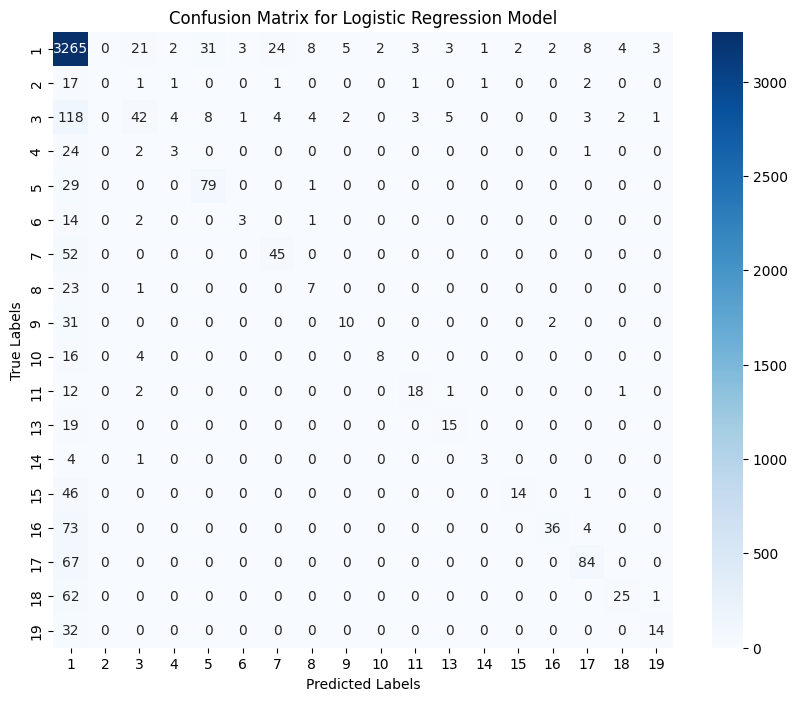

In [146]:
from sklearn.metrics import average_precision_score

average_precisions = []
for i in range(y_val.shape[1]):
    ap = average_precision_score(y_val.iloc[:, i], y_pred_rf[:, i])
    average_precisions.append(ap)

# Calculate mean average precision
mean_ap = sum(average_precisions) / len(average_precisions)
print(f"Mean Average Precision (mAP) Random Forest : {mean_ap:.4f}")

confusion_marice_multilabel(y_val, y_pred_rf, classes)


## Expérimentation avec deep learning

In [260]:
X_train = train[['Processed_Caption']]
X_val = val[['Processed_Caption']]
X_test = test[['Processed_Caption']]

y_train = train[labels_cols]
y_val = val[labels_cols]
y_test = test[labels_cols]



In [261]:
def multi_label_threshold(y_pred, threshold=0.5, threshold_nb=None):
    if threshold_nb is not None:
        y_pred_top3 = np.zeros_like(y_pred, dtype=int)
        for i in range(len(y_pred)):
            top_indices = np.argsort(y_pred[i])[-threshold_nb:]
            y_pred_top3[i, top_indices] = 1
        
        return y_pred_top3
    
    return (y_pred > threshold).astype(int)

In [262]:
def mean_avg_precision(y_true, y_pred):
    precision = []
    for i in range(len(y_true)):
        true_positives = np.sum(y_true.iloc[i].values & y_pred[i])
        predicted_positives = np.sum(y_pred[i])
        if predicted_positives > 0:
            precision.append(true_positives / predicted_positives)
        else:
            precision.append(0)

    avg_precision = np.mean(precision)
    return avg_precision

### Scratch LSTM with embedding

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer


max_sequence_length = 100 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Processed_Caption'])
word_index = tokenizer.word_index
print(f"Vocabulaire: {len(word_index)} mots uniques")

# 2. Conversion des textes en séquences d'indices
tf_train_sequence = tokenizer.texts_to_sequences(X_train['Processed_Caption'])
tf_val_sequence = tokenizer.texts_to_sequences(X_val['Processed_Caption'])
tf_test_sequence = tokenizer.texts_to_sequences(X_test['Processed_Caption'])

# 3. Padding des séquences (pour assurer une longueur uniforme)
tf_train = pad_sequences(tf_train_sequence, maxlen=max_sequence_length, padding='post', dtype='int32')
tf_val = pad_sequences(tf_val_sequence, maxlen=max_sequence_length, padding='post', dtype='int32')
tf_test = pad_sequences(tf_test_sequence, maxlen=max_sequence_length, padding='post', dtype='int32')

# mlb = MultiLabelBinarizer()
# tf_y_train = mlb.fit_transform(y_train)
# tf_y_val = mlb.transform(y_val)
# tf_y_test = mlb.transform(y_test)

Vocabulaire: 6018 mots uniques


In [264]:
import os
import numpy as np

# Chemin vers le fichier d'embeddings GloVe
glove_dir = '../data'
embedding_file = os.path.join(glove_dir, 'glove.6B.300d.txt')  # Ajustez le chemin
embedding_dim = 300  # Dimension des embeddings GloVe

# Charger les embeddings GloVe dans un dictionnaire
embeddings_index = {}
with open(embedding_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f"Trouvé {len(embeddings_index)} vecteurs d'embeddings GloVe.")

# Créer une matrice d'embedding qui sera utilisée par la couche Embedding
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Les mots qui ne sont pas trouvés dans l'embedding index resteront à zéro
        embedding_matrix[i] = embedding_vector

# Vérifier la proportion de mots trouvés
words_found = 0
for word, i in word_index.items():
    if embeddings_index.get(word) is not None:
        words_found += 1
print(f"Proportion de mots trouvés: {words_found / len(word_index):.2%}")

Trouvé 400000 vecteurs d'embeddings GloVe.
Proportion de mots trouvés: 94.13%


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Construire le modèle LSTM avec GloVe
model = Sequential([
    Embedding(
        input_dim=len(word_index) + 1,
        output_dim=embedding_dim,      
        input_length=max_sequence_length,
        weights=[embedding_matrix],
        trainable=False            
    ),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(len(classes), activation='sigmoid') 
])

# Compiler le modèle
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC']
)

model.build(input_shape=(None, max_sequence_length))

model.summary()

c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ (None, 100, 300)       │     1,805,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 100, 128)       │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,075,926 (7.92 MB)

 Trainable params: 270,226 (1.03 MB)

 Non-trainable params: 1,805,700 (6.89 MB)

In [274]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    # ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# Entraîner le modèle
history = model.fit(
    tf_train, y_train,
    validation_data=(tf_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=callbacks
)

evaluation = model.evaluate(tf_val, y_val, verbose=0)
print(f"Évaluation sur l'ensemble de validation: {evaluation}")

Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 56s 163ms/step - AUC: 0.7699 - loss: 0.2800 - val_AUC: 0.8059 - val_loss: 0.2035
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 58s 177ms/step - AUC: 0.7984 - loss: 0.2052 - val_AUC: 0.8092 - val_loss: 0.2040
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 62s 188ms/step - AUC: 0.8027 - loss: 0.2032 - val_AUC: 0.8096 - val_loss: 0.2033
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 58s 175ms/step - AUC: 0.8034 - loss: 0.2017 - val_AUC: 0.8092 - val_loss: 0.2042
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 59s 178ms/step - AUC: 0.8043 - loss: 0.2028 - val_AUC: 0.8089 - val_loss: 0.2033
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 53s 162ms/step - AUC: 0.8047 - loss: 0.2026 - val_AUC: 0.8097 - val_loss: 0.2032
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 56s 172ms/step - AUC: 0.8044 - loss: 0.2030 - val_AUC: 0.8099 - val_loss: 0.2034
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 59s 179ms/step - AUC: 0.8075 - loss: 0.2004 - val_AUC: 0.8100 - val_loss: 0.2032
Epoch 9/10
329/329 ━━━━━━━━━━━━━

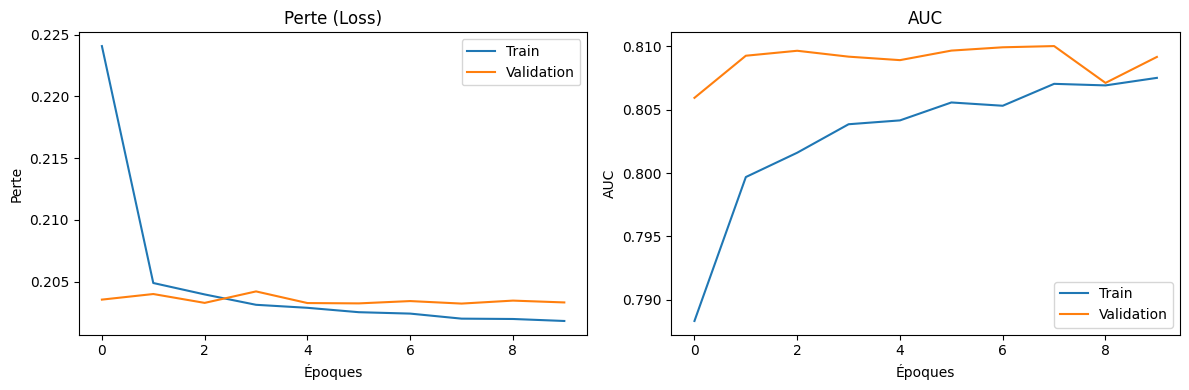

In [275]:
import matplotlib.pyplot as plt

# Tracer l'historique de perte (loss)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Perte (Loss)')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['AUC'], label='Train')
plt.plot(history.history['val_AUC'], label='Validation')
plt.title('AUC')
plt.xlabel('Époques')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
Mean Average Precision (mAP) LSTM: 0.3271


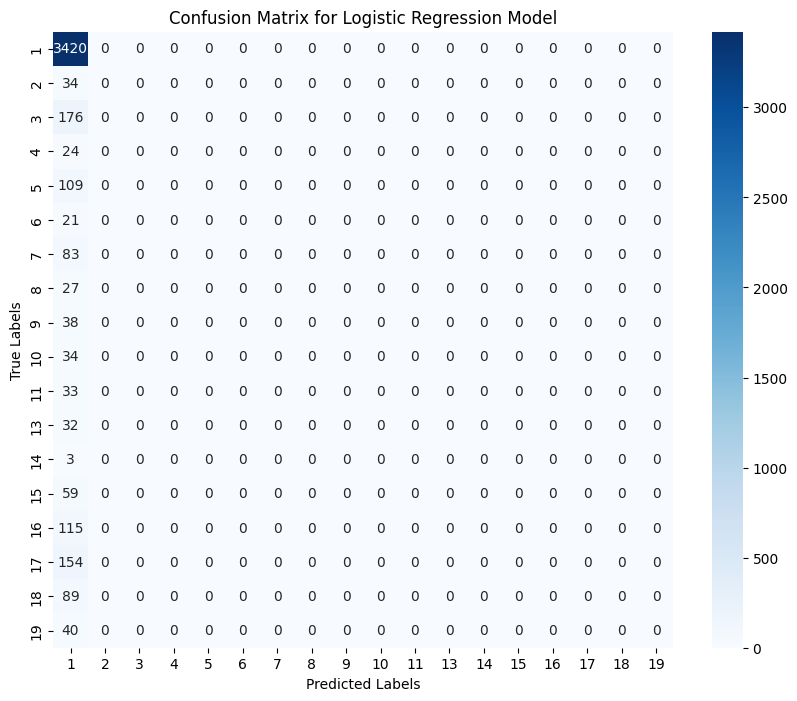

In [276]:

y_pred_proba = model.predict(tf_test)

# Sélectionner les 3 classes avec les plus hautes probabilités pour chaque exemple
y_pred_top3 = multi_label_threshold(y_pred_proba, threshold_nb=3)

print(f"Mean Average Precision (mAP) LSTM: {mean_avg_precision(y_test, y_pred_top3):.4f}")

confusion_marice_multilabel(y_test, y_pred_top3, classes)

### LSTM, Bi-LSTM et 1D CNN

In [292]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.initializers import Constant

hybrid_model = Sequential([
    Embedding(
        input_dim=len(word_index) + 1,
        output_dim=embedding_dim,      
        input_length=max_sequence_length,
        weights=[embedding_matrix],
        trainable=False            
    ),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(128, return_sequences=True),
    Bidirectional(LSTM(128, return_sequences=True)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='sigmoid')
])


hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
hybrid_model.build(input_shape=(None, max_sequence_length))
hybrid_model.summary()

c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)        │ (None, 100, 300)       │     1,805,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 96, 128)        │       192,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 48, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 48, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,967,894 (15.14 MB)

 Trainable params: 2,162,194 (8.25 MB)

 Non-trainable params: 1,805,700 (6.89 MB)

In [293]:
hybrid_model.fit(
    tf_train, y_train,
    validation_data=(tf_val, y_val), 
    epochs=10, 
    batch_size=32,
    callbacks=callbacks
)

evaluation = hybrid_model.evaluate(tf_val, y_val, verbose=0)
print(f"Évaluation sur l'ensemble de validation: {evaluation}")

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 60s 87ms/step - AUC: 0.8603 - loss: 0.2054 - val_AUC: 0.9626 - val_loss: 0.1014
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 62s 94ms/step - AUC: 0.9582 - loss: 0.1048 - val_AUC: 0.9659 - val_loss: 0.0930
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 60s 92ms/step - AUC: 0.9678 - loss: 0.0904 - val_AUC: 0.9663 - val_loss: 0.0924
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 59s 90ms/step - AUC: 0.9736 - loss: 0.0834 - val_AUC: 0.9647 - val_loss: 0.0943
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 59s 90ms/step - AUC: 0.9783 - loss: 0.0762 - val_AUC: 0.9617 - val_loss: 0.0991
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 58s 88ms/step - AUC: 0.9819 - loss: 0.0702 - val_AUC: 0.9598 - val_loss: 0.1018
Évaluation sur l'ensemble de validation: [0.09235572069883347, 0.9662743210792542]


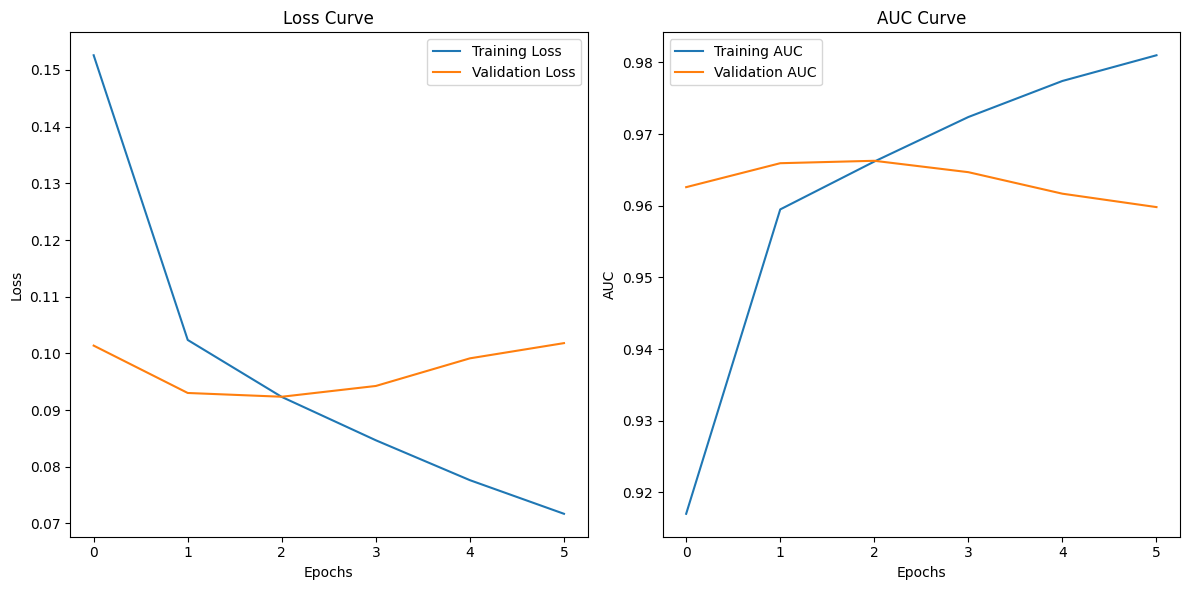

In [294]:
import matplotlib.pyplot as plt

# Tracer la courbe d'apprentissage
plt.figure(figsize=(12, 6))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(hybrid_model.history.history['loss'], label='Training Loss')
plt.plot(hybrid_model.history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(hybrid_model.history.history['AUC'], label='Training AUC')
plt.plot(hybrid_model.history.history['val_AUC'], label='Validation AUC')
plt.title('AUC Curve')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step
Mean Average Precision (mAP) Hybrid Model: 0.4505


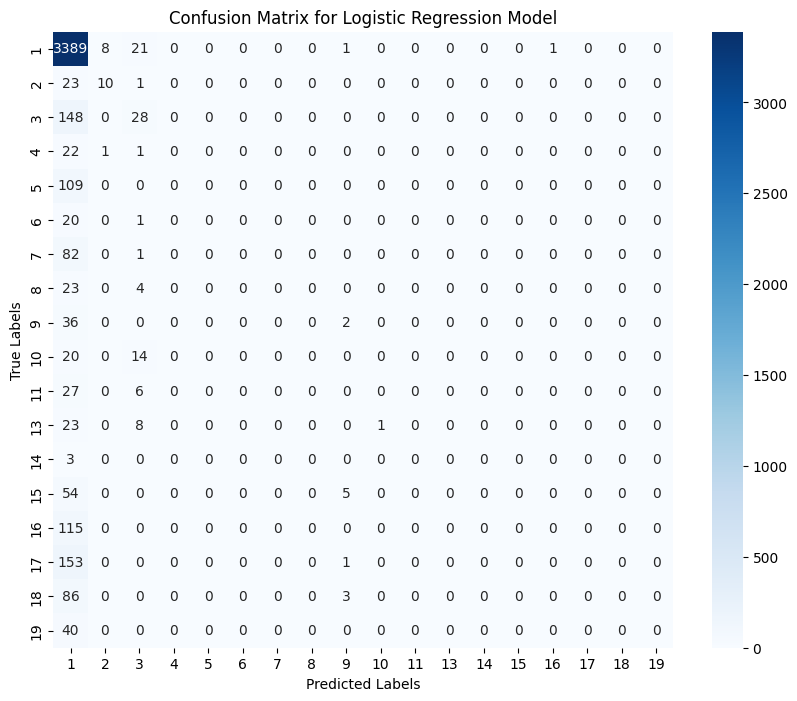

In [295]:
y_pred_proba = hybrid_model.predict(tf_test)
y_pred_top3 = multi_label_threshold(y_pred_proba, threshold_nb=3)

print(f"Mean Average Precision (mAP) Hybrid Model: {mean_avg_precision(y_test, y_pred_top3):.4f}")
confusion_marice_multilabel(y_test, y_pred_top3, classes)

### LSTM with Glove embedding

In [285]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.initializers import Constant


# Construire le modèle LSTM avec les embeddings GloVe
model_glove = Sequential([
    Embedding(
        input_dim=len(word_index) + 1,
        output_dim=embedding_dim,      
        input_length=max_sequence_length,
        weights=[embedding_matrix],
        trainable=False            
    ),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(len(classes), activation='sigmoid')
])

# Compiler le modèle
model_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_glove.build(input_shape=(None, max_sequence_length))
model_glove.summary()

c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)        │ (None, 100, 300)       │     1,805,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 100, 128)       │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,075,926 (7.92 MB)

 Trainable params: 270,226 (1.03 MB)

 Non-trainable params: 1,805,700 (6.89 MB)

In [286]:
model_glove.fit(
    tf_train, y_train,
    validation_data=(tf_val, y_val), 
    epochs=10, 
    batch_size=32,
    callbacks=callbacks
)

evaluation = model_glove.evaluate(tf_val, y_val, verbose=0)
print(f"Évaluation sur l'ensemble de validation: {evaluation}")

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 56s 82ms/step - AUC: 0.7761 - loss: 0.2510 - val_AUC: 0.8074 - val_loss: 0.2035
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 55s 84ms/step - AUC: 0.7999 - loss: 0.2048 - val_AUC: 0.8060 - val_loss: 0.2035
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 59s 90ms/step - AUC: 0.8037 - loss: 0.2032 - val_AUC: 0.8087 - val_loss: 0.2035
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 70s 107ms/step - AUC: 0.8066 - loss: 0.2036 - val_AUC: 0.8094 - val_loss: 0.2033
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 74s 112ms/step - AUC: 0.8019 - loss: 0.2043 - val_AUC: 0.8087 - val_loss: 0.2035
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 78s 119ms/step - AUC: 0.8086 - loss: 0.2023 - val_AUC: 0.8070 - val_loss: 0.2035
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 72s 109ms/step - AUC: 0.8085 - loss: 0.2024 - val_AUC: 0.8080 - val_loss: 0.2033
Évaluation sur l'ensemble de validation: [0.20327278971672058, 0.8093539476394653]


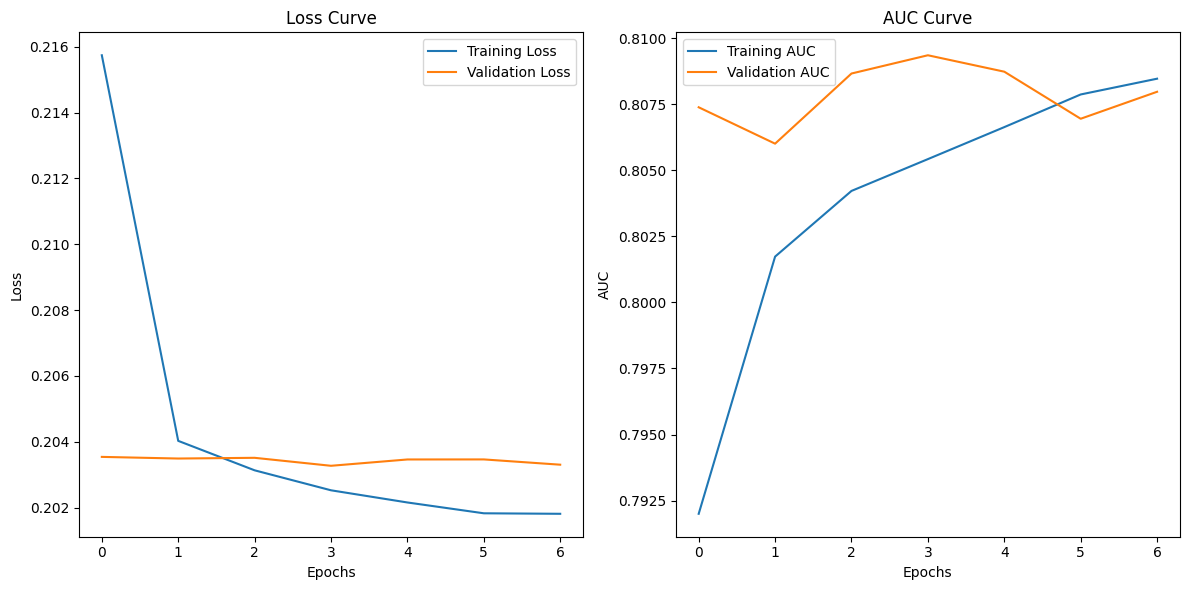

In [287]:
import matplotlib.pyplot as plt

# Tracer la courbe d'apprentissage
plt.figure(figsize=(12, 6))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(model_glove.history.history['loss'], label='Training Loss')
plt.plot(model_glove.history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(model_glove.history.history['AUC'], label='Training AUC')
plt.plot(model_glove.history.history['val_AUC'], label='Validation AUC')
plt.title('AUC Curve')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
Mean Average Precision (mAP) LSTM with GloVe: 0.3271


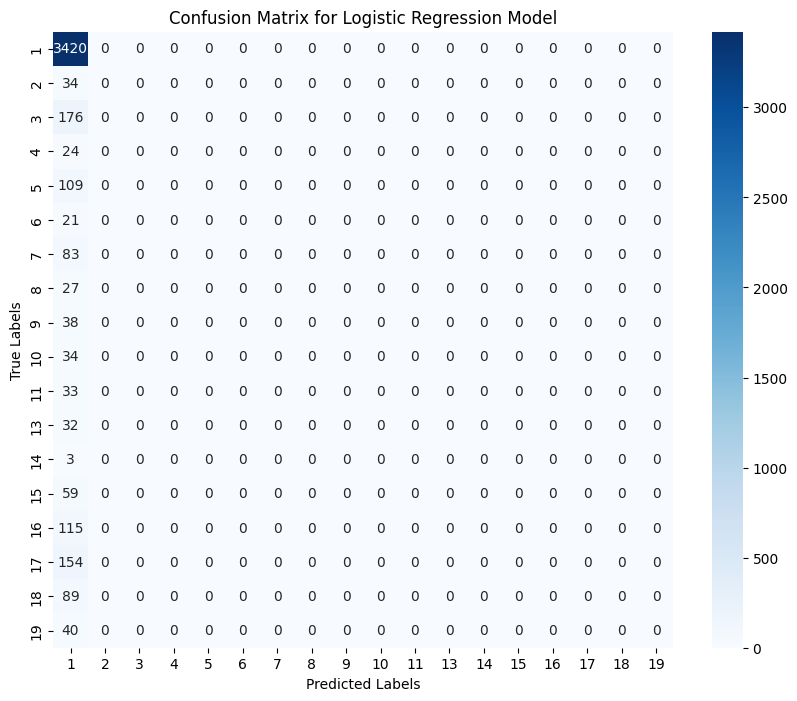

In [289]:

y_pred_proba_glove = model_glove.predict(tf_test)
# Sélectionner les 3 classes avec les plus hautes probabilités pour chaque exemple
y_pred_top3_glove = multi_label_threshold(y_pred_proba_glove, threshold_nb=3)
print(f"Mean Average Precision (mAP) LSTM with GloVe: {mean_avg_precision(y_test, y_pred_top3_glove):.4f}")
confusion_marice_multilabel(y_test, y_pred_top3_glove, classes)

### LSTM with Glove embedding and CNN

In [296]:
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate


lstm_cnn_model = Sequential([
    Embedding(
        input_dim=len(word_index) + 1,
        output_dim=embedding_dim,      
        input_length=max_sequence_length,
        weights=[embedding_matrix],
        trainable=False            
    ),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(128, return_sequences=False),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(len(classes), activation='sigmoid')
])

# Compiler le modèle
lstm_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
lstm_cnn_model.build(input_shape=(None, max_sequence_length))

# Résumé du modèle
lstm_cnn_model.summary()

c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)        │ (None, 100, 300)       │     1,805,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 96, 128)        │       192,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,138,838 (8.16 MB)

 Trainable params: 333,138 (1.27 MB)

 Non-trainable params: 1,805,700 (6.89 MB)

In [297]:
lstm_cnn_model.fit(
    tf_train, y_train,
    validation_data=(tf_val, y_val),
    epochs=10, 
    batch_size=32,
    callbacks=callbacks
)

evaluation = lstm_cnn_model.evaluate(tf_val, y_val, verbose=0)
print(f"Évaluation sur l'ensemble de validation: {evaluation}")

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - AUC: 0.7524 - loss: 0.2855 - val_AUC: 0.8086 - val_loss: 0.2045
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - AUC: 0.7929 - loss: 0.2102 - val_AUC: 0.8075 - val_loss: 0.2034
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - AUC: 0.7941 - loss: 0.2071 - val_AUC: 0.8076 - val_loss: 0.2033
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 32s 49ms/step - AUC: 0.7991 - loss: 0.2053 - val_AUC: 0.8089 - val_loss: 0.2032
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - AUC: 0.8023 - loss: 0.2033 - val_AUC: 0.8096 - val_loss: 0.2034
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - AUC: 0.7994 - loss: 0.2061 - val_AUC: 0.8100 - val_loss: 0.2032
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - AUC: 0.7992 - loss: 0.2038 - val_AUC: 0.8090 - val_loss: 0.2035
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - AUC: 0.7999 - loss: 0.2041 - val_AUC: 0.8093 - val_loss: 0.2034
Epoch 9/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 

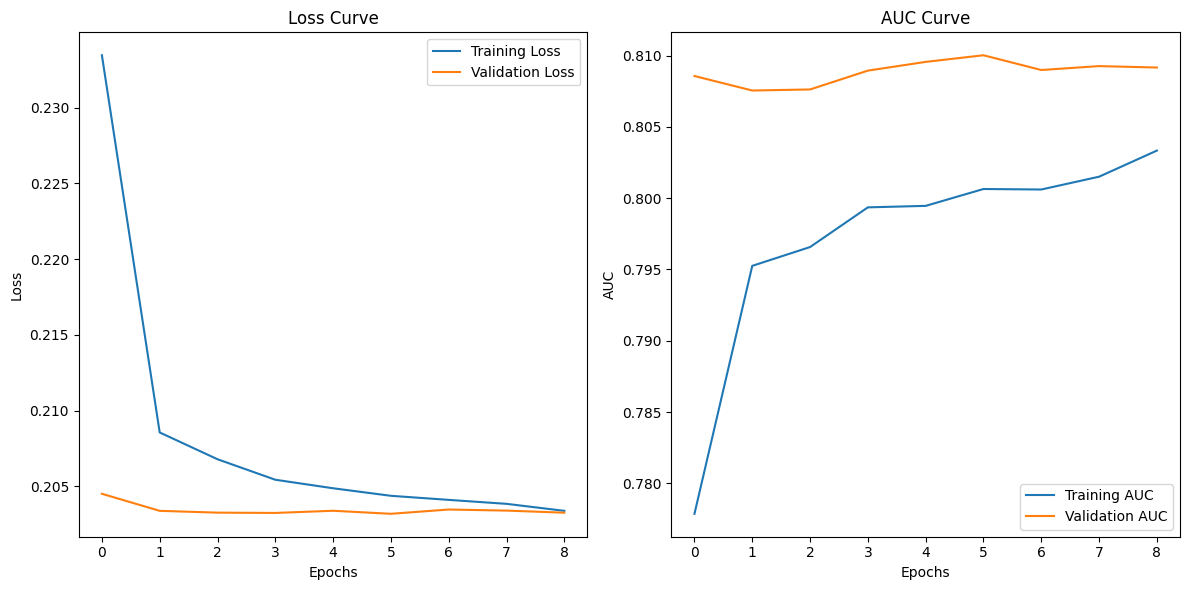

In [298]:

# Tracer la courbe d'apprentissage
plt.figure(figsize=(12, 6))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(lstm_cnn_model.history.history['loss'], label='Training Loss')
plt.plot(lstm_cnn_model.history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(lstm_cnn_model.history.history['AUC'], label='Training AUC')
plt.plot(lstm_cnn_model.history.history['val_AUC'], label='Validation AUC')
plt.title('AUC Curve')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Mean Average Precision (mAP) Hybrid Model: 0.3271


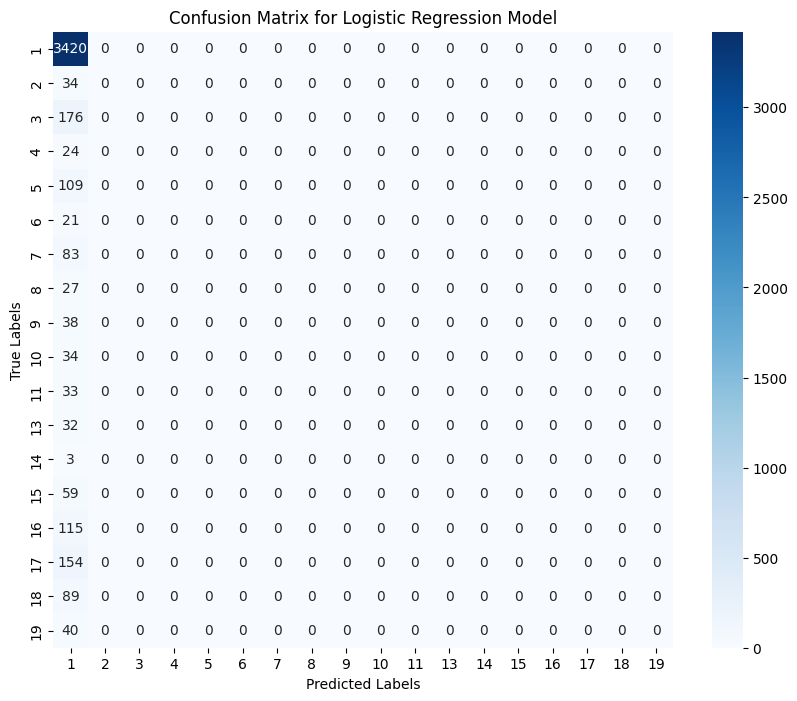

In [299]:
y_pred_proba_hybrid = lstm_cnn_model.predict(tf_test)
# Sélectionner les 3 classes avec les plus hautes probabilités pour chaque exemple
y_pred_top3_hybrid = multi_label_threshold(y_pred_proba_hybrid, threshold_nb=3)

print(f"Mean Average Precision (mAP) Hybrid Model: {mean_avg_precision(y_test, y_pred_top3_hybrid):.4f}")

confusion_marice_multilabel(y_test, y_pred_top3_hybrid, classes)

## Comparatif et conclusion

Pour comparer les differents modeles que nous avons testé, nous allons utiliser la matrice de confusion et le mAp (mean Average Precision) pour evaluer la performance de nos modeles. 

* La matrice de confusion : Nous permet de visualiser les performances des modeles et il est ressort qu'eux tous predisent majoritairement la classe 1 qui est la classe majoritaire.
* Le mAP : Il est calculé en prenant la moyenne des précisions pour chaque classe. Il est plus adapté pour les classes déséquilibrées car il prend en compte la précision de chaque classe individuellement.

En conclusion, le modele avec les meilleures performances est le modele de Regression Logistique avec un mAP de 0.6.
En plus il est plus rapide et plus simple à mettre en place que les autres modeles.
Donc c'est le modele que nous allons utiliser pour la suite de notre projet.

### Quelques exemples

In [159]:

num_examples = 2
for i in range(num_examples):
    random_index = np.random.randint(0, len(test))
    X = X_test.iloc[random_index:random_index+1]
    y = y_test.iloc[random_index:random_index+1]
    predict = lr_model.predict(X)
    predict_proba = lr_model.predict_proba(X)
    
    print(f"Texte: {test['Processed_Caption'].iloc[random_index]}")
    print(f"Vrai Labels: {y.values}")
    print(f"Prédictions: {predict}")
    print(f"Probabilités: {np.round(predict_proba, 2)}")
    print("-"*50)

Texte: man sitting looking monitor pen mouth
Vrai Labels: [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Prédictions: [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Probabilités: [[0.95 0.01 0.03 0.   0.   0.   0.01 0.01 0.01 0.   0.   0.   0.   0.01
  0.02 0.01 0.02 0.  ]]
--------------------------------------------------
Texte: man kite laid sand
Vrai Labels: [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Prédictions: [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Probabilités: [[1.   0.01 0.03 0.   0.   0.   0.   0.05 0.04 0.   0.   0.   0.   0.01
  0.01 0.01 0.   0.  ]]
--------------------------------------------------


### Explicability du modele LIME

In [161]:
%pip install lime

     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/275.7 kB ? eta -:--:--
     ---------- -------------------------- 81.9/275.7 kB 919.0 kB/s eta 0:00:01
     ------------------- ------------------ 143.4/275.7 kB 1.1 MB/s eta 0:00:01
     ---------------------------- --------- 204.8/275.7 kB 1.2 MB/s eta 0:00:01
     -------------------------------------- 275.7/275.7 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for scikit-image>=0.12 from https://files.pythonhosted.org/packages/de/ec/b57c500ee85885df5f2188f8bb70398481393a69de44a00d6f1d055f103c/scikit_image-0.25.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for networkx>=3.0 from https://files.pythonhosted.org/packages/b9/54/dd730b32ea14ea797530a4479b2ed46a6fb250f682a9cfb997e968bf0261/networkx-3.4.2-py3-none-any.whl.metadata



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [163]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np


# Créer un explainer LIME
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=classes,
    mode='classification'
)

# Sélectionner un exemple à expliquer
example_index = 0
example_data = X_val.iloc[example_index].values
example_label = y_val.iloc[example_index].values

# Générer une explication pour cet exemple
explanation = explainer.explain_instance(
    data_row=example_data,
    predict_fn=lr_model.predict_proba,
    num_features=10
)

# Afficher l'explication
from IPython.display import display, HTML
html = explanation.as_html(show_predicted_value=True)
display(HTML(html))

c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\sklearn\utils\validation

Ici nous avons l'explicabilité mais sur les embeddings et pas sur les textes directement.

Pour ameliorer la classification, nous pourrions utiliser un modele de langue préentrainé comme BERT ou GPT-3. Ces modeles sont capables de comprendre le contexte et les relations entre les mots et ce malgré le desequilibre des classes